In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-13 19:20:08--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-09-13 19:20:08 (4.04 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



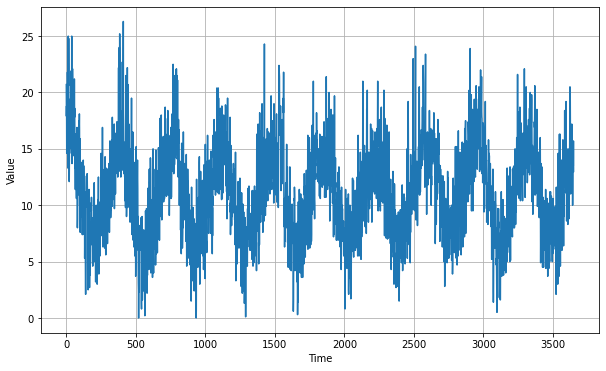

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)

    for i, line in enumerate(reader):
        time_step.append(i)
        temps.append(float(line[1]))


series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x: (x[:-1], x[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    return model.predict(ds.batch(32).prefetch(1))

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, padding='causal', activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Lambda(lambda x: x * 25.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 23ms/step - loss: 2.8013 - mae: 3.2697
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 2.8012 - mae: 3.2696
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 2.8012 - mae: 3.2696
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 2.8011 - mae: 3.2695
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 2.8010 - mae: 3.2694
Epoch 6/100
10/10 [==============================] - 0s 31ms/step - loss: 2.8009 - mae: 3.2693
Epoch 7/100
10/10 [==============================] - 0s 30ms/step - loss: 2.8007 - mae: 3.2691
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 2.8006 - mae: 3.2690
Epoch 9/100
10/10 [==============================] - 0s 34ms/step - loss: 2.8004 - mae: 3.2688
Epoch 10/100
10/10 [=======================

(1e-08, 0.001, 0.0, 4.0)

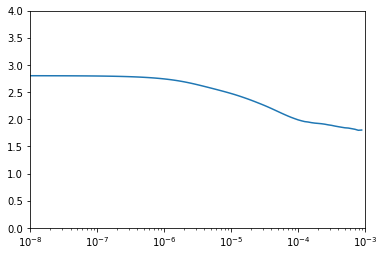

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 4])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, padding='causal', activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Lambda(lambda x: x * 25.0)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 0s 18ms/step - loss: 2.2481 - mae: 2.7078
Epoch 2/30
25/25 [==============================] - 0s 14ms/step - loss: 1.9401 - mae: 2.3935
Epoch 3/30
25/25 [==============================] - 0s 14ms/step - loss: 1.8483 - mae: 2.3008
Epoch 4/30
25/25 [==============================] - 0s 14ms/step - loss: 1.8010 - mae: 2.2532
Epoch 5/30
25/25 [==============================] - 0s 16ms/step - loss: 1.7682 - mae: 2.2192
Epoch 6/30
25/25 [==============================] - 0s 16ms/step - loss: 1.7301 - mae: 2.1802
Epoch 7/30
25/25 [==============================] - 0s 16ms/step - loss: 1.7091 - mae: 2.1585
Epoch 8/30
25/25 [==============================] - 0s 15ms/step - loss: 1.6625 - mae: 2.1111
Epoch 9/30
25/25 [==============================] - 0s 14ms/step - loss: 1.6531 - mae: 2.1004
Epoch 10/30
25/25 [==============================] - 0s 14ms/step - loss: 1.6054 - mae: 2.0516
Epoch 11/30
25/25 [==============================] - 0s 15m

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

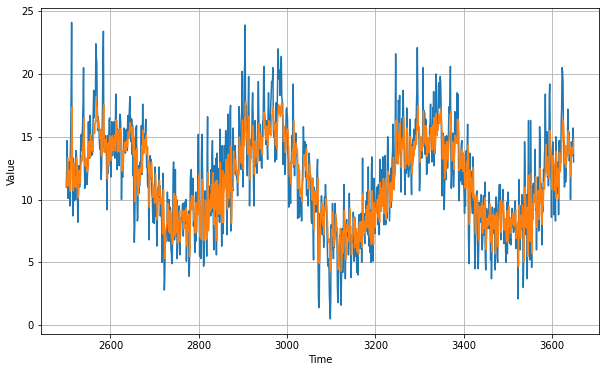

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.795953

In [14]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.357653 11.041581 12.181215 ... 13.672204 13.675998 14.76259 ]
